In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import sklearn
import pandas as pd
import os, sys, time

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

In [2]:
for model in (mpl, plt. np, sklearn, pd, tf):
    print(model.__name__, model.__version__)

matplotlib 3.1.1
numpy 1.17.4
sklearn 0.22
pandas 0.25.3
tensorflow 2.1.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [4]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_imagines(3, 5, x_train, y_train, class_names)

NameError: name 'show_imagines' is not defined

In [8]:
print(np.max(x_train), np.min(x_train))

255 0


In [5]:
# x = (x - u) / std  减均值中心化，均值为0. 除方差，归一化标准差变为1
#使数据符合均值0，方差1的正态分布
#增加了基向量的正交性，标准的数据加速权重参数收敛
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaler = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaler = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [6]:
print(np.max(x_train_scaler), np.min(x_train_scaler))

2.0231433 -0.8105136


In [7]:
# tf.kears.models.Sequential()

# model = keras.models.Sequential()
# #28*28的图像平铺为长为28*28的向量
# model.add(keras.layers.Flatten(input_shape=[28, 28]))
# #添加全连接层
# model.add(keras.layers.Dense(300, activation='sigmoid'))
# model.add(keras.layers.Dense(100, activation='sigmoid'))
# #输出层（因为是十类分类，所以输出结果是长度为10的向量，每个值表示概率）
# model.add(keras.layers.Dense(10, activation='sigmoid'))

#relu y = max(0, x)
#softmax 向量变成概率分布
#        x = [x1, x2, x3]   y=[e^x1/e^x1+e^x2+e^x3,  e^x2//e^x1+e^x2+e^x3, e^x3/e^x1+e^x2+e^x3]

#reasons for sparse: y->index y->one_hot->[] 获取的label是单个数值，需要转为onehot，所这里用了sparse
#sgd optimizer模型求解方法，
#accuracy metrcis 关注的指标 

model = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]), 
                                 keras.layers.Dense(300, activation='relu'), 
                                 keras.layers.Dense(100, activation='relu'), 
                                 keras.layers.Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd', metrics=['accuracy'])


In [8]:
model.layers

In [9]:
#ex 23500 = 784*300(满足矩阵乘法)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


# callback函数
## 对正在训练中的模型进行一些操作

In [10]:
# callback操作Tensorboard， earlystopping，ModelCheckpoint

#定义一个callback日志文件夹
logdir = os.path.join('callbacks')
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callback = [keras.callbacks.TensorBoard(logdir), 
            keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True), #只保留最好的，默认保留最新的
            keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)] 
#min_delta最小优化阈值。patience未达到阈值要求下，几次迭代后停止。monitor关注哪一个指标，一般是验证集上目标函数的值 。
history = model.fit(x_train_scaler, y_train, epochs=10, validation_data=(x_valid_scaler, y_valid), callbacks=callback)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 118us/sample - loss: 0.5308 - accuracy: 0.8130 - val_loss: 0.4118 - val_accuracy: 0.8592
Epoch 2/10
55000/55000 [==============================] - 6s 114us/sample - loss: 0.3911 - accuracy: 0.8607 - val_loss: 0.3945 - val_accuracy: 0.8562
Epoch 3/10
55000/55000 [==============================] - 6s 113us/sample - loss: 0.3546 - accuracy: 0.8715 - val_loss: 0.3447 - val_accuracy: 0.8786
Epoch 4/10
55000/55000 [==============================] - 6s 106us/sample - loss: 0.3292 - accuracy: 0.8809 - val_loss: 0.3512 - val_accuracy: 0.8722
Epoch 5/10
55000/55000 [==============================] - 6s 111us/sample - loss: 0.3106 - accuracy: 0.8867 - val_loss: 0.3294 - val_accuracy: 0.8768
Epoch 6/10
55000/55000 [==============================] - 6s 118us/sample - loss: 0.2939 - accuracy: 0.8936 - val_loss: 0.3150 - val_accuracy: 0.8840
Epoch 7/10
55000/55000 [===========================

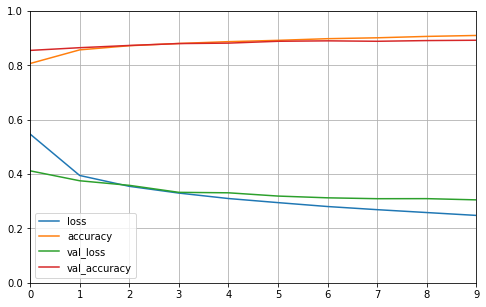

In [15]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [16]:
model.evaluate(x_test_scaler, y_test)

10000/10000 [==============================] - 1s 70us/sample - loss: 0.3342 - accuracy: 0.8814


[0.3341592279314995, 0.8814]